![](images/explainability_0.jpg)

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,4)

## Loding data

In [134]:
#Importing dataset
df= pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,5.8,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


In [135]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

## Explore class separability

### T-SNE

In [136]:
from sklearn.manifold import TSNE

In [137]:
x_tsne = TSNE().fit_transform(X)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


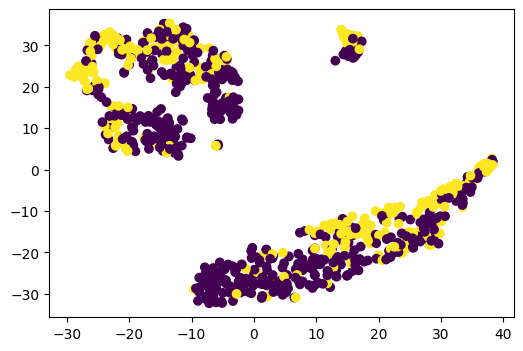

In [15]:
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)

## Classification

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.20)

### Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
model = LogisticRegression(max_iter=1000)

In [25]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [26]:
y_pred = model.predict(X_test)

In [27]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       115
           1       0.47      0.69      0.56        39

    accuracy                           0.72       154
   macro avg       0.67      0.71      0.68       154
weighted avg       0.77      0.72      0.74       154



## Random Forest (bagging)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [35]:
model = RandomForestClassifier()

In [39]:
model_sel.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 8],
                                        'n_estimators': [100, 300, 500]})

In [40]:
model_sel.best_params_

{'n_estimators': 500, 'max_depth': 5, 'criterion': 'entropy'}

In [43]:
y_pred = model.predict(X_test)

In [44]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       117
           1       0.45      0.70      0.55        37

    accuracy                           0.72       154
   macro avg       0.67      0.71      0.67       154
weighted avg       0.78      0.72      0.74       154



## Gradient Boosting

In [110]:
from sklearn.ensemble import GradientBoostingClassifier as XGBClassifier

In [111]:
model = XGBClassifier()

In [112]:
model.fit(X_train,y_train)

GradientBoostingClassifier()

In [113]:
y_pred = model.predict(X_test)

In [114]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78       113
           1       0.47      0.66      0.55        41

    accuracy                           0.71       154
   macro avg       0.66      0.69      0.67       154
weighted avg       0.75      0.71      0.72       154



<AxesSubplot: >

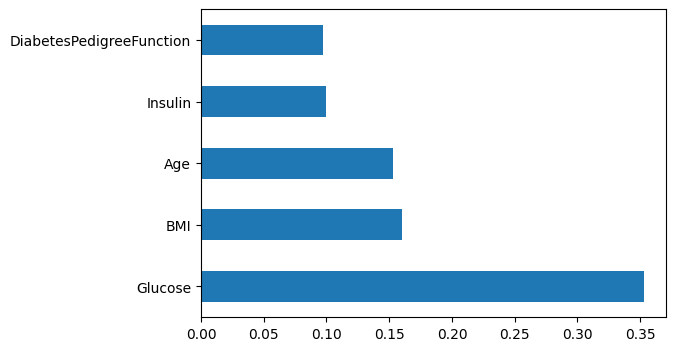

In [115]:
feat_importances = pd.Series(model.feature_importances_, index = X.columns)

feat_importances.nlargest(5).plot(kind = 'barh')

In [116]:
from sklearn.tree import plot_tree

In [130]:
model[0][0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x7F551E13EA40)

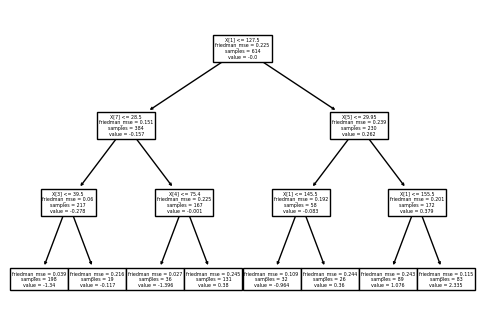

In [132]:
_=plot_tree(model[0][0])

## Using Lime

![](images/lime.png)

In [78]:
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train, 
                                 feature_names = X.columns, 
                                 class_names = ['Diabetes -ve', 'Diabetes +ve'], 
                                 feature_selection = "lasso_path", 
                                 discretize_continuous = True, 
                                 discretizer = "quartile", 
                                 verbose = True, 
                                 mode = 'classification')

Intercept 0.3576467377775861
Prediction_local [0.28465168]
Right: 0.037099946


/home/alabarga/BSC/code/environments/ironhack/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(


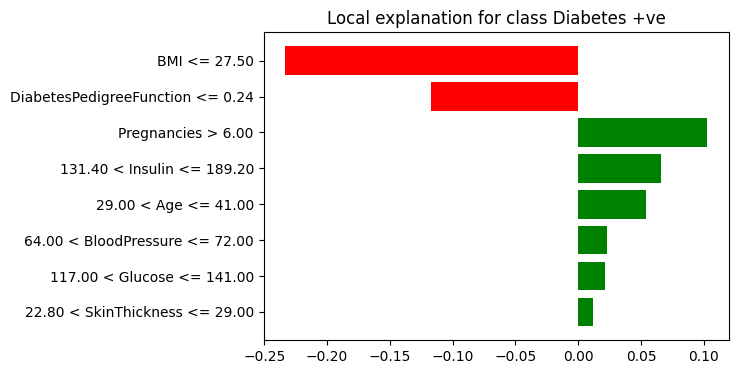

In [80]:
exp = explainer.explain_instance(X_test[0,], model.predict_proba)

_ = exp.as_pyplot_figure()

In [81]:
exp.show_in_notebook(show_table = True, show_all = False)

## Using SHAP

![](images/shap_1.png)

![](images/shap_0.png)

In [82]:
import shap

In [83]:
shap.initjs()

In [84]:
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(X_train, 10)


In [85]:
ex = shap.KernelExplainer(model.predict, X_train_summary)


X does not have valid feature names, but KNNImputer was fitted with feature names


In [86]:

obs= X_test[0,]
shap_values = ex.shap_values(obs)
shap.force_plot(ex.expected_value, shap_values, obs)

X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names


In [88]:
shap_values = ex.shap_values(X_test)

  0%|          | 0/154 [00:00<?, ?it/s]

X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have 

X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have 

X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have valid feature names, but KNNImputer was fitted with feature names
X does not have 

X does not have valid feature names, but KNNImputer was fitted with feature names


  0%|          | 0/154 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


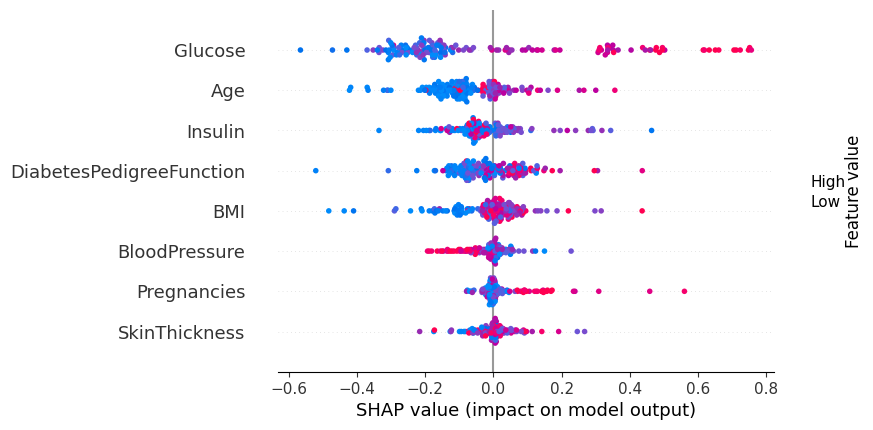

In [224]:

shap.summary_plot(shap_values, X_test, X.columns)

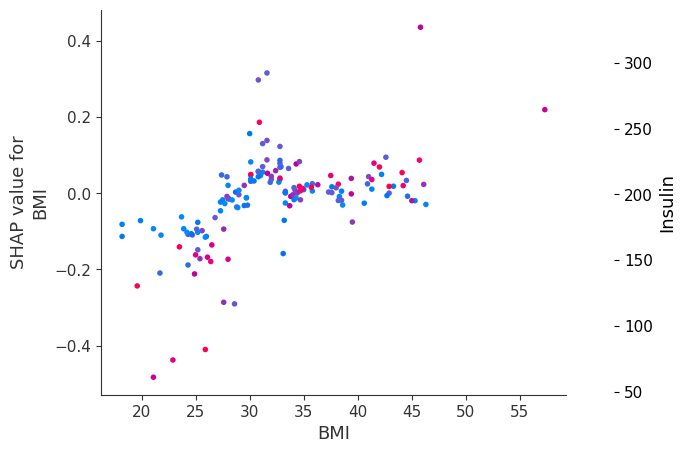

In [228]:
shap.dependence_plot("BMI", shap_values, pd.DataFrame(X_test, columns=X.columns))